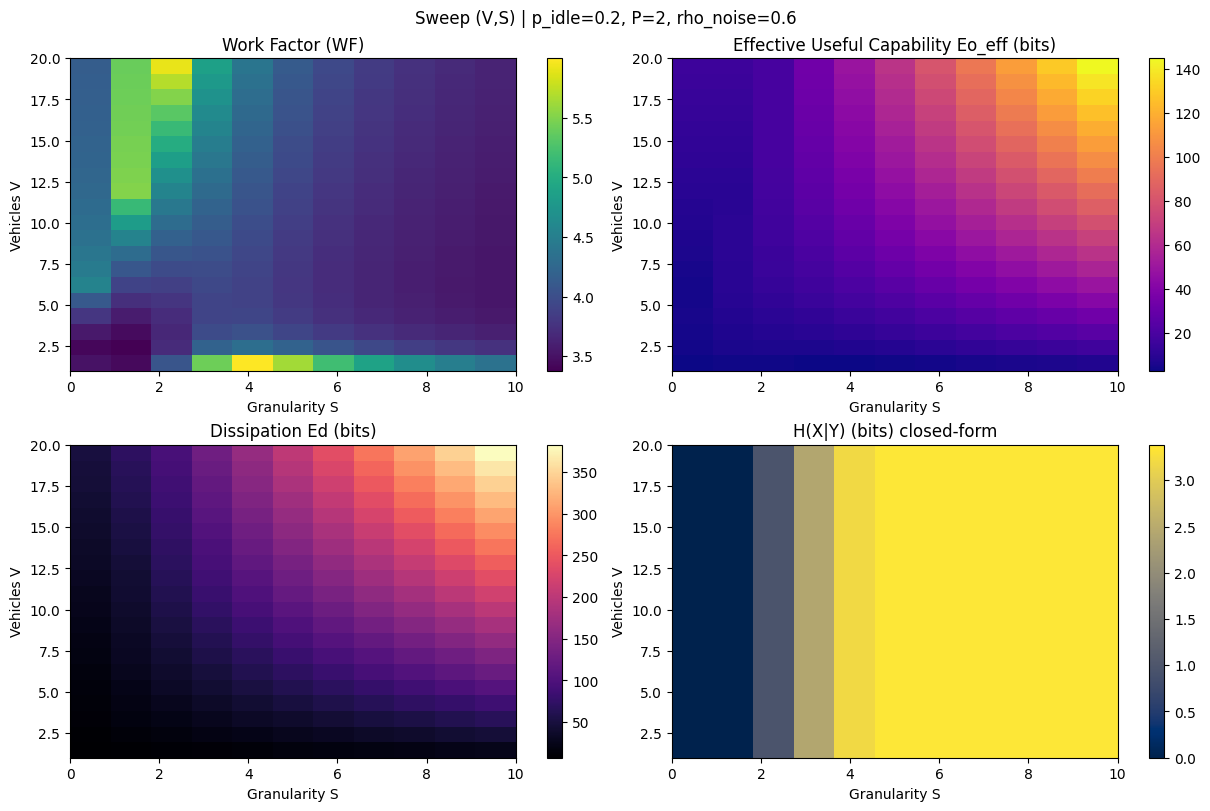

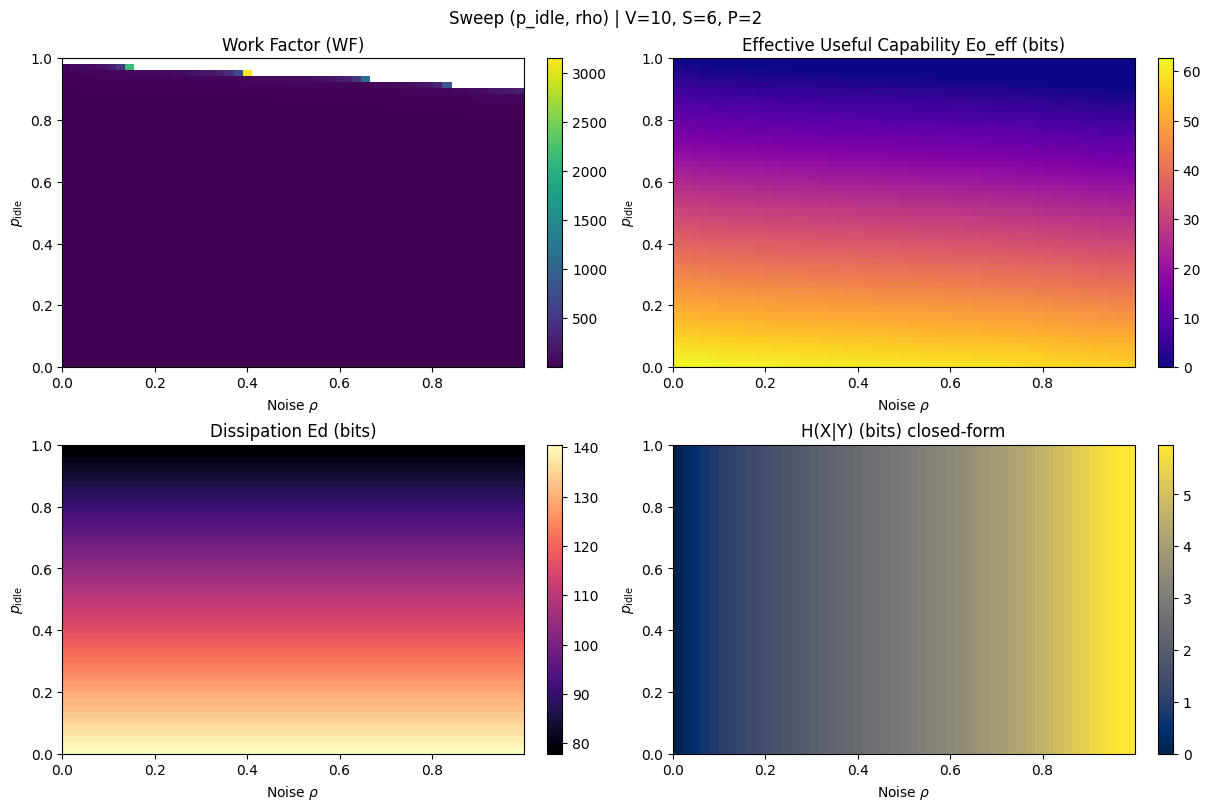

Single-point result:
  V=10, S=6, p_idle=0.25, P=2, NA_bits=auto, rho_noise=0.7
  H(X|Y) (bits)=3.915
  Eo_eff(bits)=43.058, Ed(bits)=125.634, WF=3.918


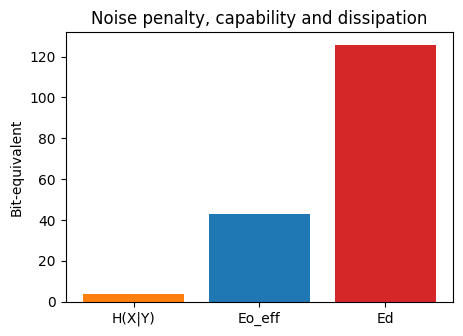

In [1]:

# Minimal Work Factor simulation template (updated with sweep for p_idle and rho)
# ------------------------------------------------------------------------------
# - WF = 1 + Ed / Eo_eff
# - Eo_eff = max( (1 - p_idle) * V * NA_bits - H(X|Y), 0 )
# - H(X|Y) (fechada): circular, P(X|Y) ∝ rho^{distância}, com multiplicidades por distância.

import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# Binary entropy
# ---------------------------
def Hb(p: float) -> float:
    """Entropia binária H_b(p) em bits."""
    p = np.clip(p, 1e-12, 1 - 1e-12)
    return -(p*np.log2(p) + (1-p)*np.log2(1-p))

# ---------------------------
# Action-space bound (bits)
# ---------------------------
def default_NA_bits(V: int, S: int, P: int) -> float:
    """
    Proxy superior para o tamanho do espaço de ações N_A em *bits*:
      N_A <= log2((P+1) * 2^S * P^P / V)
    (Limitado a pelo menos 1 bit por sanidade).
    """
    val = np.log2((P + 1) * (2**S) * (P**P) / max(V, 1))
    return max(val, 1.0)

# ---------------------------
# Closed-form H(X|Y) no círculo com decaimento exponencial
# ---------------------------
def H_conditional_closed_form(S: int, rho: float) -> float:
    """
    H(X|Y) para um círculo com K = 2^S posições.
    P(X|Y) ∝ rho^{d(X,Y)}, onde d é a distância circular mínima.

    Parâmetros
    ----------
    S : int
        Granularidade (número de slots K = 2^S).
    rho : float
        Parâmetro de decaimento em (0, 1]. Para rho=0, H=0 (determinístico).

    Retorna
    -------
    H_bits : float
        Entropia condicional H(X|Y) em bits.
    """
    if rho <= 0:
        return 0.0
    K = 2**S                   # número de posições
    N = K - 1
    M = N // 2                 # floor(N/2)

    # Multiplicidades m_k para distâncias k=0..M
    m = np.zeros(M + 1, dtype=float)
    m[0] = 1.0
    if K % 2 == 0:             # K par: distância mais longe tem multiplicidade 1
        if M >= 1:
            m[1:M] = 2.0
        m[M] = 1.0             # k = K/2 == M
    else:                      # K ímpar: todas 1..M têm multiplicidade 2
        if M >= 1:
            m[1:M+1] = 2.0

    ks = np.arange(M + 1, dtype=float)
    rho_pows = rho ** ks

    # Partição Z = sum_x rho^{d(x,y)} = sum_k m_k * rho^k
    Z = np.sum(m * rho_pows)

    # Fórmula fechada: H = log2 Z - (log2 rho / Z) * sum( m_k * k * rho^k )
    sum_term = np.sum(m * ks * rho_pows)
    H_bits = np.log2(Z) - (np.log2(rho) * sum_term) / Z
    return float(H_bits)

# ---------------------------
# Work Factor model (sem depth/alpha_depth/rho global)
# ---------------------------
def work_factor(V: int, S: int, p_idle: float, P: int = 2, NA_bits: float | None = None, rho_noise: float = 0.5):
    """
    WF = 1 + Ed / Eo_eff com redução de Eo pela H(X|Y) fechada.

    Parâmetros
    ----------
    V : int
        Nº de veículos.
    S : int
        Granularidade (K = 2^S slots).
    p_idle : float
        Probabilidade de o sistema permanecer sem intervenção.
    P : int, default=2
        Nº de plataformas.
    NA_bits : float or None
        Tamanho do conjunto de ações em bits; se None, usa bound padrão.
    rho_noise : float, default=0.5
        Parâmetro de ruído do modelo P(X|Y) ∝ rho^{distância} (sensing/communication noise).

    Retorna
    -------
    WF : float
        Work Factor.
    Ed_bits : float
        Dissipação (bit-equivalente).
    Eo_eff_bits : float
        Capacidade útil efetiva após redução por H(X|Y).
    HXY_bits : float
        Entropia condicional usada na redução.
    """
    # Ações (bits)
    NA = default_NA_bits(V, S, P) if NA_bits is None else max(NA_bits, 1.0)

    # Dissipação Ed (bits)
    action_diss = Hb(p_idle) + (1 - p_idle) * V * NA
    sc_diss = V * np.log2(P + 1) + P * np.log2(max(P, 1)) + S * V
    Ed_bits = action_diss + sc_diss

    # H(X|Y) (fechada) para o estado granular G
    HXY_bits = H_conditional_closed_form(S=S, rho=rho_noise)

    # Capacidade útil efetiva com penalização por incerteza
    Eo_base = (1 - p_idle) * V * NA
    Eo_eff_bits = max(Eo_base - HXY_bits, 0.0)

    if Eo_eff_bits <= 1e-12:
        return np.inf, Ed_bits, Eo_eff_bits, HXY_bits

    WF = 1.0 + Ed_bits / Eo_eff_bits
    return WF, Ed_bits, Eo_eff_bits, HXY_bits

# ---------------------------
# Sweep (V, S)
# ---------------------------
def sweep_V_S(V_list=range(1, 21), S_list=range(0, 11), p_idle=0.2, P=2, rho_noise=0.5):
    """Heatmaps de WF, Eo_eff, Ed e H(X|Y) variando V e S."""
    V_arr = np.array(list(V_list))
    S_arr = np.array(list(S_list))

    WF_grid = np.zeros((len(V_arr), len(S_arr)))
    Ed_grid = np.zeros_like(WF_grid)
    Eo_grid = np.zeros_like(WF_grid)
    Hxy_grid = np.zeros_like(WF_grid)

    for i, V in enumerate(V_arr):
        for j, S in enumerate(S_arr):
            WF, Ed, Eo_eff, Hxy = work_factor(V, S, p_idle, P=P, NA_bits=None, rho_noise=rho_noise)
            WF_grid[i, j] = WF
            Ed_grid[i, j] = Ed
            Eo_grid[i, j] = Eo_eff
            Hxy_grid[i, j] = Hxy

    fig, axs = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

    im0 = axs[0, 0].imshow(WF_grid, aspect='auto', origin='lower',
                           extent=[S_arr.min(), S_arr.max(), V_arr.min(), V_arr.max()], cmap='viridis')
    axs[0, 0].set_title('Work Factor (WF)')
    axs[0, 0].set_xlabel('Granularity S')
    axs[0, 0].set_ylabel('Vehicles V')
    plt.colorbar(im0, ax=axs[0, 0])

    im1 = axs[0, 1].imshow(Eo_grid, aspect='auto', origin='lower',
                           extent=[S_arr.min(), S_arr.max(), V_arr.min(), V_arr.max()], cmap='plasma')
    axs[0, 1].set_title('Effective Useful Capability Eo_eff (bits)')
    axs[0, 1].set_xlabel('Granularity S')
    axs[0, 1].set_ylabel('Vehicles V')
    plt.colorbar(im1, ax=axs[0, 1])

    im2 = axs[1, 0].imshow(Ed_grid, aspect='auto', origin='lower',
                           extent=[S_arr.min(), S_arr.max(), V_arr.min(), V_arr.max()], cmap='magma')
    axs[1, 0].set_title('Dissipation Ed (bits)')
    axs[1, 0].set_xlabel('Granularity S')
    axs[1, 0].set_ylabel('Vehicles V')
    plt.colorbar(im2, ax=axs[1, 0])

    im3 = axs[1, 1].imshow(Hxy_grid, aspect='auto', origin='lower',
                           extent=[S_arr.min(), S_arr.max(), V_arr.min(), V_arr.max()], cmap='cividis')
    axs[1, 1].set_title('H(X|Y) (bits) closed-form')
    axs[1, 1].set_xlabel('Granularity S')
    axs[1, 1].set_ylabel('Vehicles V')
    plt.colorbar(im3, ax=axs[1, 1])

    fig.suptitle(f"Sweep (V,S) | p_idle={p_idle}, P={P}, rho_noise={rho_noise}", fontsize=12)
    plt.show()

# ---------------------------
# Sweep (p_idle, rho)
# ---------------------------
def sweep_pidle_rho(pidle_list=np.linspace(0, 1, 51),
                    rho_list=np.linspace(0, 0.999, 51),
                    V: int = 10, S: int = 6, P: int = 2, NA_bits: float | None = None):
    """
    Heatmaps de WF, Eo_eff, Ed e H(X|Y) variando p_idle e rho (ruído),
    mantendo V, S e P fixos.
    """
    pid_arr = np.array(list(pidle_list))
    rho_arr = np.array(list(rho_list))

    WF_grid = np.zeros((len(pid_arr), len(rho_arr)))
    Ed_grid = np.zeros_like(WF_grid)
    Eo_grid = np.zeros_like(WF_grid)
    Hxy_grid = np.zeros_like(WF_grid)

    for i, p_idle in enumerate(pid_arr):
        for j, rho in enumerate(rho_arr):
            WF, Ed, Eo_eff, Hxy = work_factor(V, S, p_idle, P=P, NA_bits=NA_bits, rho_noise=rho)
            WF_grid[i, j] = WF
            Ed_grid[i, j] = Ed
            Eo_grid[i, j] = Eo_eff
            Hxy_grid[i, j] = Hxy

    fig, axs = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

    im0 = axs[0, 0].imshow(WF_grid, aspect='auto', origin='lower',
                           extent=[rho_arr.min(), rho_arr.max(), pid_arr.min(), pid_arr.max()], cmap='viridis')
    axs[0, 0].set_title('Work Factor (WF)')
    axs[0, 0].set_xlabel(r'Noise $\rho$')
    axs[0, 0].set_ylabel(r'$p_{\mathrm{idle}}$')
    plt.colorbar(im0, ax=axs[0, 0])

    im1 = axs[0, 1].imshow(Eo_grid, aspect='auto', origin='lower',
                           extent=[rho_arr.min(), rho_arr.max(), pid_arr.min(), pid_arr.max()], cmap='plasma')
    axs[0, 1].set_title('Effective Useful Capability Eo_eff (bits)')
    axs[0, 1].set_xlabel(r'Noise $\rho$')
    axs[0, 1].set_ylabel(r'$p_{\mathrm{idle}}$')
    plt.colorbar(im1, ax=axs[0, 1])

    im2 = axs[1, 0].imshow(Ed_grid, aspect='auto', origin='lower',
                           extent=[rho_arr.min(), rho_arr.max(), pid_arr.min(), pid_arr.max()], cmap='magma')
    axs[1, 0].set_title('Dissipation Ed (bits)')
    axs[1, 0].set_xlabel(r'Noise $\rho$')
    axs[1, 0].set_ylabel(r'$p_{\mathrm{idle}}$')
    plt.colorbar(im2, ax=axs[1, 0])

    im3 = axs[1, 1].imshow(Hxy_grid, aspect='auto', origin='lower',
                           extent=[rho_arr.min(), rho_arr.max(), pid_arr.min(), pid_arr.max()], cmap='cividis')
    axs[1, 1].set_title('H(X|Y) (bits) closed-form')
    axs[1, 1].set_xlabel(r'Noise $\rho$')
    axs[1, 1].set_ylabel(r'$p_{\mathrm{idle}}$')
    plt.colorbar(im3, ax=axs[1, 1])

    fig.suptitle(f"Sweep (p_idle, rho) | V={V}, S={S}, P={P}", fontsize=12)
    plt.show()

# ---------------------------
# Single point
# ---------------------------
def single_point(V=12, S=8, p_idle=0.3, P=2, NA_bits=None, rho_noise=0.5):
    """Imprime e plota H(X|Y), Eo_eff, Ed e WF para uma configuração."""
    WF, Ed, Eo_eff, Hxy = work_factor(V, S, p_idle, P=P, NA_bits=NA_bits, rho_noise=rho_noise)
    print(f"Single-point result:")
    print(f"  V={V}, S={S}, p_idle={p_idle}, P={P}, NA_bits={'auto' if NA_bits is None else f'{NA_bits:.3f}'}, rho_noise={rho_noise}")
    print(f"  H(X|Y) (bits)={Hxy:.3f}")
    print(f"  Eo_eff(bits)={Eo_eff:.3f}, Ed(bits)={Ed:.3f}, WF={WF:.3f}")

    labels = ['H(X|Y)', 'Eo_eff', 'Ed']
    vals = [Hxy, Eo_eff, Ed]
    plt.figure(figsize=(5,3.5))
    plt.bar(labels, vals, color=['tab:orange', 'tab:blue', 'tab:red'])
    plt.title('Noise penalty, capability and dissipation')
    plt.ylabel('Bit-equivalent')
    plt.show()

# ---------------------------
# Exemplos rápidos de execução
# ---------------------------
# 1) Sweep (V, S)
sweep_V_S(V_list=range(1, 21), S_list=range(0, 11), p_idle=0.2, P=2, rho_noise=0.6)

# 2) Sweep (p_idle, rho) para V,S fixos
sweep_pidle_rho(pidle_list=np.linspace(0, 1, 51),
                rho_list=np.linspace(0, 0.999, 51),
                V=10, S=6, P=2, NA_bits=None)

# 3) Ponto único
single_point(V=10, S=6, p_idle=0.25, P=2, NA_bits=None, rho_noise=0.7)


In [2]:

# -*- coding: utf-8 -*-
"""
Generate .dat files for Work Factor model sweeps and provide helper functions.
"""

import numpy as np

# ---------- Entropia binária ----------
def Hb(p: float) -> float:
    p = np.clip(p, 1e-12, 1 - 1e-12)
    return -(p*np.log2(p) + (1-p)*np.log2(1-p))

# ---------- Bound (bits) para N_A ----------
def default_NA_bits(V: int, S: int, P: int) -> float:
    val = np.log2((P + 1) * (2**S) * (P**P) / max(V, 1))
    return max(val, 1.0)

# ---------- H(X|Y) fechado, circular com decaimento exponencial ----------
def H_conditional_closed_form(S: int, rho: float) -> float:
    if rho <= 0:
        return 0.0
    K = 2**S
    N = K - 1
    M = N // 2

    m = np.zeros(M + 1, dtype=float)
    m[0] = 1.0
    if K % 2 == 0:
        if M >= 1: m[1:M] = 2.0
        m[M] = 1.0
    else:
        if M >= 1: m[1:M+1] = 2.0

    ks = np.arange(M + 1, dtype=float)
    rho_pows = rho ** ks
    Z = np.sum(m * rho_pows)
    sum_term = np.sum(m * ks * rho_pows)
    H_bits = np.log2(Z) - (np.log2(rho) * sum_term) / Z
    return float(H_bits)

# ---------- Work Factor ----------
def work_factor(V: int, S: int, p_idle: float, P: int = 2, NA_bits: float | None = None, rho_noise: float = 0.5):
    NA = default_NA_bits(V, S, P) if NA_bits is None else max(NA_bits, 1.0)
    action_diss = Hb(p_idle) + (1 - p_idle) * V * NA
    sc_diss = V * np.log2(P + 1) + P * np.log2(max(P, 1)) + S * V
    Ed_bits = action_diss + sc_diss
    HXY_bits = H_conditional_closed_form(S=S, rho=rho_noise)
    Eo_base = (1 - p_idle) * V * NA
    Eo_eff_bits = max(Eo_base - HXY_bits, 0.0)
    if Eo_eff_bits <= 1e-12:
        return np.inf, Ed_bits, Eo_eff_bits, HXY_bits
    WF = 1.0 + Ed_bits / Eo_eff_bits
    return WF, Ed_bits, Eo_eff_bits, HXY_bits

# ---------- Helper: escrever .dat ----------
def _write_dat(filename: str, header: str, data: np.ndarray):
    with open(filename, 'w', encoding='utf-8') as f:
        f.write('# ' + header.strip() + '\n')
        np.savetxt(f, data, fmt='%.6f')

# ---------- Salvar sweep (V,S) ----------
def save_sweep_V_S_dat(prefix: str,
                       V_list=range(1, 21),
                       S_list=range(0, 11),
                       p_idle: float = 0.2,
                       P: int = 2,
                       rho_noise: float = 0.6):
    V_arr = np.array(list(V_list), dtype=float)
    S_arr = np.array(list(S_list), dtype=float)
    rows_WF, rows_Ed, rows_Eo, rows_HXY = [], [], [], []
    for V in V_arr:
        for S in S_arr:
            WF, Ed, Eo_eff, Hxy = work_factor(int(V), int(S), p_idle, P=P, NA_bits=None, rho_noise=rho_noise)
            rows_WF.append([V, S, WF])
            rows_Ed.append([V, S, Ed])
            rows_Eo.append([V, S, Eo_eff])
            rows_HXY.append([V, S, Hxy])
    _write_dat(f"{prefix}_WF.dat", "V  S  WF", np.array(rows_WF))
    _write_dat(f"{prefix}_Ed.dat", "V  S  Ed_bits", np.array(rows_Ed))
    _write_dat(f"{prefix}_Eo_eff.dat", "V  S  Eo_eff_bits", np.array(rows_Eo))
    _write_dat(f"{prefix}_HXY.dat", "V  S  HXY_bits", np.array(rows_HXY))

# ---------- Salvar sweep (p_idle, rho) ----------
def save_sweep_pidle_rho_dat(prefix: str,
                             pidle_list=np.linspace(0, 1, 51),
                             rho_list=np.linspace(0, 0.999, 51),
                             V: int = 10,
                             S: int = 6,
                             P: int = 2,
                             NA_bits: float | None = None):
    pid_arr = np.array(list(pidle_list), dtype=float)
    rho_arr = np.array(list(rho_list), dtype=float)
    rows_WF, rows_Ed, rows_Eo, rows_HXY = [], [], [], []
    for p_idle in pid_arr:
        for rho in rho_arr:
            WF, Ed, Eo_eff, Hxy = work_factor(V, S, p_idle, P=P, NA_bits=NA_bits, rho_noise=rho)
            rows_WF.append([p_idle, rho, WF])
            rows_Ed.append([p_idle, rho, Ed])
            rows_Eo.append([p_idle, rho, Eo_eff])
            rows_HXY.append([p_idle, rho, Hxy])
    _write_dat(f"{prefix}_WF.dat", "p_idle  rho  WF", np.array(rows_WF))
    _write_dat(f"{prefix}_Ed.dat", "p_idle  rho  Ed_bits", np.array(rows_Ed))
    _write_dat(f"{prefix}_Eo_eff.dat", "p_idle  rho  Eo_eff_bits", np.array(rows_Eo))
    _write_dat(f"{prefix}_HXY.dat", "p_idle  rho  HXY_bits", np.array(rows_HXY))

# ---------- Exemplos: gerar arquivos .dat ----------
if __name__ == "__main__":
    save_sweep_V_S_dat(prefix='results_VS', V_list=range(1, 11), S_list=range(0, 7), p_idle=0.2, P=2, rho_noise=0.6)
    save_sweep_pidle_rho_dat(prefix='results_pidrho', V=10, S=6, P=2,
                             pidle_list=np.linspace(0, 1, 21),
                             rho_list=np.linspace(0, 0.999, 21))
    print('DAT files generated: results_VS_*.dat and results_pidrho_*.dat')


DAT files generated: results_VS_*.dat and results_pidrho_*.dat


In [3]:

# -*- coding: utf-8 -*-
"""
Exporta arquivos .dat com colunas:
  - S  WF  Eo_eff  Ed     (S = 0..10)
  - p_idle  WF  Eo_eff  Ed  (p_idle = 0..1)
  - V  WF  Eo_eff  Ed     (V = 1..10)

Repete a geração para uma lista de valores de rho (ruído).
"""

from __future__ import annotations
import numpy as np
from pathlib import Path

# ---------------------------
# Entropia binária
# ---------------------------
def Hb(p: float) -> float:
    p = np.clip(p, 1e-12, 1 - 1e-12)
    return -(p*np.log2(p) + (1-p)*np.log2(1-p))

# ---------------------------
# Bound (bits) para N_A
# ---------------------------
def default_NA_bits(V: int, S: int, P: int) -> float:
    # bound simples em bits (>= 1.0)
    val = np.log2((P + 1) * (2**S) * (P**P) / max(V, 1))
    return max(val, 1.0)

# ---------------------------
# H(X|Y) fechado: círculo com K = 2^S, P(X|Y) ∝ rho^{distância}
# ---------------------------
def H_conditional_closed_form(S: int, rho: float) -> float:
    if rho <= 0:
        return 0.0
    K = 2**S
    N = K - 1
    M = N // 2

    # multiplicidades por distância k=0..M
    m = np.zeros(M + 1, dtype=float)
    m[0] = 1.0
    if K % 2 == 0:       # K par: distância mais distante tem multiplicidade 1
        if M >= 1:
            m[1:M] = 2.0
        m[M] = 1.0
    else:                # K ímpar: distâncias 1..M têm multiplicidade 2
        if M >= 1:
            m[1:M+1] = 2.0

    ks = np.arange(M + 1, dtype=float)
    rho_pows = rho ** ks
    Z = np.sum(m * rho_pows)
    sum_term = np.sum(m * ks * rho_pows)
    H_bits = np.log2(Z) - (np.log2(rho) * sum_term) / Z
    return float(H_bits)

# ---------------------------
# Work Factor model
# ---------------------------
def work_factor(V: int, S: int, p_idle: float, P: int = 2, NA_bits: float | None = None, rho_noise: float = 0.5):
    """
    Retorna: WF, Ed_bits, Eo_eff_bits, HXY_bits
    """
    # Ações (bits)
    NA = default_NA_bits(V, S, P) if NA_bits is None else max(NA_bits, 1.0)

    # Dissipação Ed (bits): ação + proxy sensor/combiner
    action_diss = Hb(p_idle) + (1 - p_idle) * V * NA
    sc_diss = V * np.log2(P + 1) + P * np.log2(max(P, 1)) + S * V
    Ed_bits = action_diss + sc_diss

    # Penalidade de ruído: H(X|Y)
    HXY_bits = H_conditional_closed_form(S=S, rho=rho_noise)

    # Capacidade útil efetiva
    Eo_base = (1 - p_idle) * V * NA
    Eo_eff_bits = max(Eo_base - HXY_bits, 0.0)

    if Eo_eff_bits <= 1e-12:
        WF = np.inf
    else:
        WF = 1.0 + Ed_bits / Eo_eff_bits

    return WF, Ed_bits, Eo_eff_bits, HXY_bits

# ---------------------------
# Export helpers
# ---------------------------
def write_dat(filepath: Path, header: str, matrix: np.ndarray):
    """
    Escreve .dat com header (comentado com '#') e colunas separadas por espaço.
    matrix: shape (n, 4) - 4 colunas conforme especificação.
    """
    filepath.parent.mkdir(parents=True, exist_ok=True)
    with open(filepath, "w", encoding="utf-8") as f:
        f.write("# " + header.strip() + "\n")
        np.savetxt(f, matrix, fmt="%.6f")

def export_by_S(
    out_path: Path,
    V_fixed: int,
    p_idle_fixed: float,
    P: int,
    rho_noise: float,
    S_min: int = 0,
    S_max: int = 10
):
    """
    Gera arquivo .dat com colunas:
      S, WF, Eo_eff, Ed
    para S = S_min..S_max.
    """
    rows = []
    for S in range(S_min, S_max + 1):
        WF, Ed, Eo_eff, _ = work_factor(V=V_fixed, S=S, p_idle=p_idle_fixed, P=P, rho_noise=rho_noise)
        rows.append([2**S, WF, Eo_eff, Ed])
    arr = np.array(rows, dtype=float)
    header = f"2^S  WF  Eo_eff  Ed   | fixed: V={V_fixed}, p_idle={p_idle_fixed}, P={P}, rho={rho_noise}"
    write_dat(out_path, header, arr)

def export_by_pidle(
    out_path: Path,
    V_fixed: int,
    S_fixed: int,
    P: int,
    rho_noise: float,
    n_points: int = 101
):
    """
    Gera arquivo .dat com colunas:
      p_idle, WF, Eo_eff, Ed
    para p_idle ∈ [0,1] com n_points pontos.
    """
    rows = []
    pidle_vals = np.linspace(0.0, 1.0, n_points)
    for p_idle in pidle_vals:
        WF, Ed, Eo_eff, _ = work_factor(V=V_fixed, S=S_fixed, p_idle=p_idle, P=P, rho_noise=rho_noise)
        rows.append([p_idle, WF, Eo_eff, Ed])
    arr = np.array(rows, dtype=float)
    header = f"p_idle  WF  Eo_eff  Ed   | fixed: V={V_fixed}, S={S_fixed}, P={P}, rho={rho_noise}"
    write_dat(out_path, header, arr)

def export_by_V(
    out_path: Path,
    S_fixed: int,
    p_idle_fixed: float,
    P: int,
    rho_noise: float,
    V_min: int = 1,
    V_max: int = 10
):
    """
    Gera arquivo .dat com colunas:
      V, WF, Eo_eff, Ed
    para V = V_min..V_max.
    """
    rows = []
    for V in range(V_min, V_max + 1):
        WF, Ed, Eo_eff, _ = work_factor(V=V, S=S_fixed, p_idle=p_idle_fixed, P=P, rho_noise=rho_noise)
        rows.append([V, WF, Eo_eff, Ed])
    arr = np.array(rows, dtype=float)
    header = f"V  WF  Eo_eff  Ed   | fixed: S={S_fixed}, p_idle={p_idle_fixed}, P={P}, rho={rho_noise}"
    write_dat(out_path, header, arr)

# ---------------------------
# Main: gera os 3 arquivos e repete para lista de rhos
# ---------------------------
if __name__ == "__main__":
    # Parâmetros fixos “default” (ajuste conforme o seu caso)
    V_fixed = 2
    S_fixed = 6
    p_idle_fixed = 0.25
    P = 2

    # Lista de rhos para repetir a exportação
    rho_list = [0, 0.25, 0.5, 0.9]

    base_dir = Path("./dat_exports")

    for rho in rho_list:
        # nomes dos arquivos incluem o valor de rho
        fname_S     = base_dir / f"S_vs_WF_EoEd_rho{rho:.3f}.dat"
        fname_pidle = base_dir / f"pidle_vs_WF_EoEd_rho{rho:.3f}.dat"
        fname_V     = base_dir / f"V_vs_WF_EoEd_rho{rho:.3f}.dat"

        # 1) variação em S (0..10)
        export_by_S(
            out_path=fname_S,
            V_fixed=V_fixed,
            p_idle_fixed=p_idle_fixed,
            P=P,
            rho_noise=rho,
            S_min=0, S_max=12
        )

        # 2) variação em p_idle (0..1)
        export_by_pidle(
            out_path=fname_pidle,
            V_fixed=V_fixed,
            S_fixed=S_fixed,
            P=P,
            rho_noise=rho,
            n_points=101
        )

        # 3) variação em V (1..10)
        export_by_V(
            out_path=fname_V,
            S_fixed=S_fixed,
            p_idle_fixed=p_idle_fixed,
            P=P,
            rho_noise=rho,
            V_min=1, V_max=10
        )

    print(f"Arquivos .dat gerados em: {base_dir.resolve()}")


Arquivos .dat gerados em: /content/dat_exports


In [4]:
!zip -r dat_exports.zip dat_exports


from google.colab import files
files.download('dat_exports.zip')

  adding: dat_exports/ (stored 0%)
  adding: dat_exports/V_vs_WF_EoEd_rho0.000.dat (deflated 45%)
  adding: dat_exports/V_vs_WF_EoEd_rho0.250.dat (deflated 44%)
  adding: dat_exports/S_vs_WF_EoEd_rho0.900.dat (deflated 52%)
  adding: dat_exports/pidle_vs_WF_EoEd_rho0.000.dat (deflated 55%)
  adding: dat_exports/S_vs_WF_EoEd_rho0.500.dat (deflated 54%)
  adding: dat_exports/V_vs_WF_EoEd_rho0.900.dat (deflated 44%)
  adding: dat_exports/pidle_vs_WF_EoEd_rho0.250.dat (deflated 56%)
  adding: dat_exports/S_vs_WF_EoEd_rho0.000.dat (deflated 58%)
  adding: dat_exports/V_vs_WF_EoEd_rho0.500.dat (deflated 44%)
  adding: dat_exports/pidle_vs_WF_EoEd_rho0.900.dat (deflated 59%)
  adding: dat_exports/S_vs_WF_EoEd_rho0.250.dat (deflated 54%)
  adding: dat_exports/pidle_vs_WF_EoEd_rho0.500.dat (deflated 57%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>